# __Bank Transaction Fraud Detection__

## __Introduction__

In this data science project, we will tackle the challenge of developing an advanced algorithm for detecting fraud in bank transactions. This topic is of utmost importance in the financial sector, as frauds pose a significant threat to both financial institutions and customers. Implementing an effective algorithm to identify fraudulent transactions can bring substantial benefits, such as reducing financial losses and enhancing customers' trust and security in banking operations.

__Potential Benefits of a Fraud Detection Algorithm__

1. Reduction of Financial Losses: Early detection of fraudulent activities can prevent significant losses for banks and customers;
2. Improved Customer Security: Increases customer confidence in banking transactions, knowing that their accounts are being monitored for suspicious activities;
3. Operational Efficiency: Reduces the time and resources spent in fraud investigation by automating the detection process;
4. Regulatory Compliance: Helps financial institutions comply with strict norms and regulations related to fraud prevention.

__Challenges in Algorithm Creation__

1. Balance between False Positives and False Negatives: A major challenge is to minimize false positives (legitimate transactions identified as fraudulent) without increasing false negatives (undetected frauds);
2. Variety of Fraud Patterns: Fraud techniques are constantly evolving, requiring the algorithm to be adaptable and frequently updated;
3. Data Protection and Privacy: Ensuring the algorithm respects customer privacy and complies with data protection laws is essential;
4. Integration with Existing Systems: The algorithm must be capable of integrating effectively with existing banking systems.

__Project Approach__

To tackle this challenge, we will test and evaluate three distinct machine learning models:

1. Catboost: Will be applied for its capacity to handle categorical data with ease, optimizing gradient boosting to achieve high performance in classification tasks;
2. Decision Tree: This model will be used for its ability to map decisions and their possible consequences, useful for identifying complex fraud patterns;
3. LightGBM: This model is designed for speed and efficiency, utilizing gradient boosting frameworks to deal with large data sets effectively. It's particularly good at handling imbalanced data, making it suitable for fraud detection;
4. Logistic Regression: This model will help estimate the probability of a transaction being fraudulent, based on the logistic relationship between independent variables.

## __Information about the data used in this project__
The dataset used in this project was obtained from the public datasets section on Kaggle at the link https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data;

### __First data view__

In [1]:
# Ignore all UserWarnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Standard and visualization imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Statistical modeling
import scipy.stats as stats

# Machine Learning models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
# Load the dataset from a CSV file into a DataFrame
df = pd.read_csv('data/Fraud.csv')

# Print the shape of the DataFrame to understand its dimensionality
# This helps in getting an initial idea of the dataset size (number of rows and columns)
print(df.shape)

# Display the first few rows of the DataFrame
# This is useful for a quick overview of the dataset, including column names and sample data
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In the same place where the above dataset was obtained, the following information is provided regarding the features contained in it:

"
__step__: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

__type__: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

__amount__: amount of the transaction in local currency.

__nameOrig__: customer who started the transaction

__oldbalanceOrg__: initial balance before the transaction

__newbalanceOrig__: new balance after the transaction

__nameDest__: customer who is the recipient of the transaction

__oldbalanceDest__: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

__newbalanceDest__: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

__isFraud__: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

__isFlaggedFraud__: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
"

In [3]:
# Count the occurrences of each unique value in the 'isFraud' column
# This is helpful to understand the distribution of fraud vs. non-fraud cases in the dataset
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

As can be seen, the dataset above is highly imbalanced, meaning there are significantly more instances of non-fraud than instances of fraud. This will certainly pose challenges in training models, especially for the occurrence we are aiming to detect, which is when a fraud actually takes place.

In [4]:
# Display a concise summary of the DataFrame including the data type of each column, and the memory usage.
# This is crucial for initial data assessment, helping to identify columns with missing values 
# and to understand the data types present in the dataset, guiding further data processing steps.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Calculate the percentage of missing values in each column of the DataFrame
# This is essential for identifying columns with high percentages of missing data,
# which may require imputation, deletion, or further investigation.
df.isnull().mean() * 100

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

At first glance, there do not appear to be major issues with the dataset beyond the problem of data imbalance. There are no missing values, which is initially a positive aspect.

### __Initial Exploratory Data Analysis__

It is always interesting to evaluate the distribution of data, its potential outliers, and consider how these characteristics might affect the performance of the models that will be used. In this specific case, the only model that directly depends on the scale of the data is the logistic regression model, so it is important to ascertain whether the data will need scaling and/or normalization in order for the model to function appropriately.

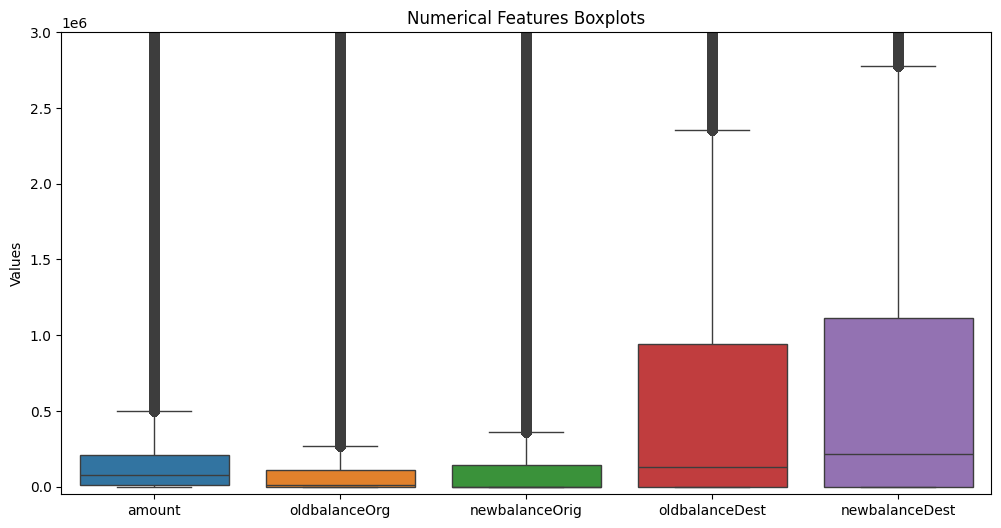

In [6]:
# Create a new figure with a specified size to make the plot larger and more readable
plt.figure(figsize=(12, 6))

# Create a boxplot for selected numerical features in the DataFrame
sns.boxplot(data=df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

# Set the y-axis limits to focus on a specific range, improving readability by excluding extreme outliers
plt.ylim(-50000, 3000000)

# Add a title to the plot to describe what it represents
plt.title('Numerical Features Boxplots')

# Label the y-axis to indicate what the values represent
plt.ylabel('Values')

# Display the plot
plt.show()

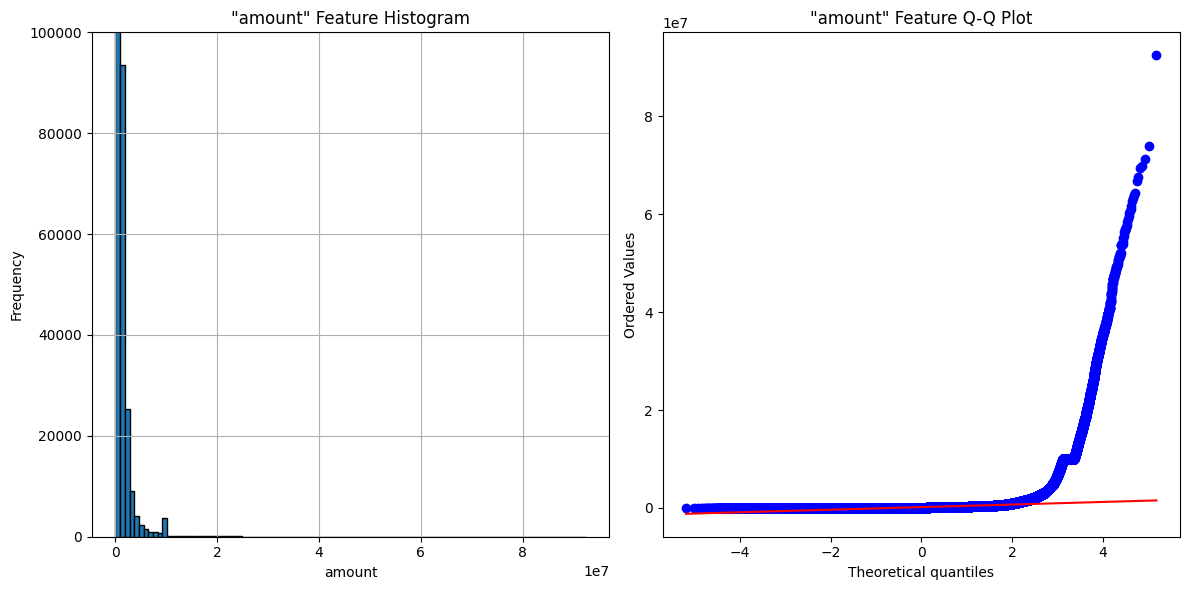

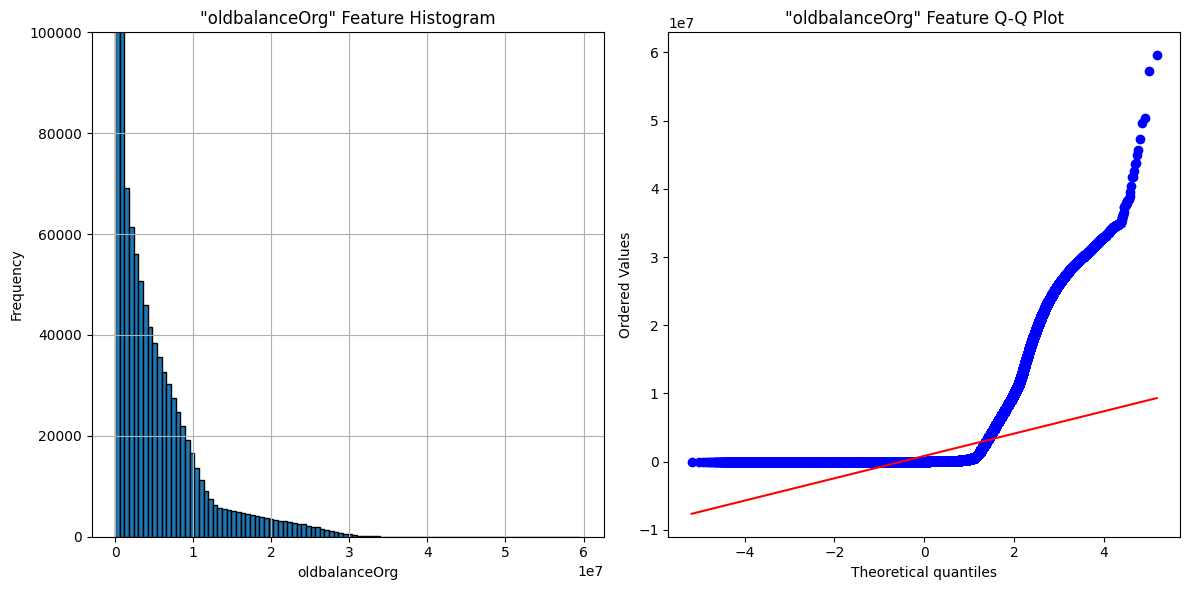

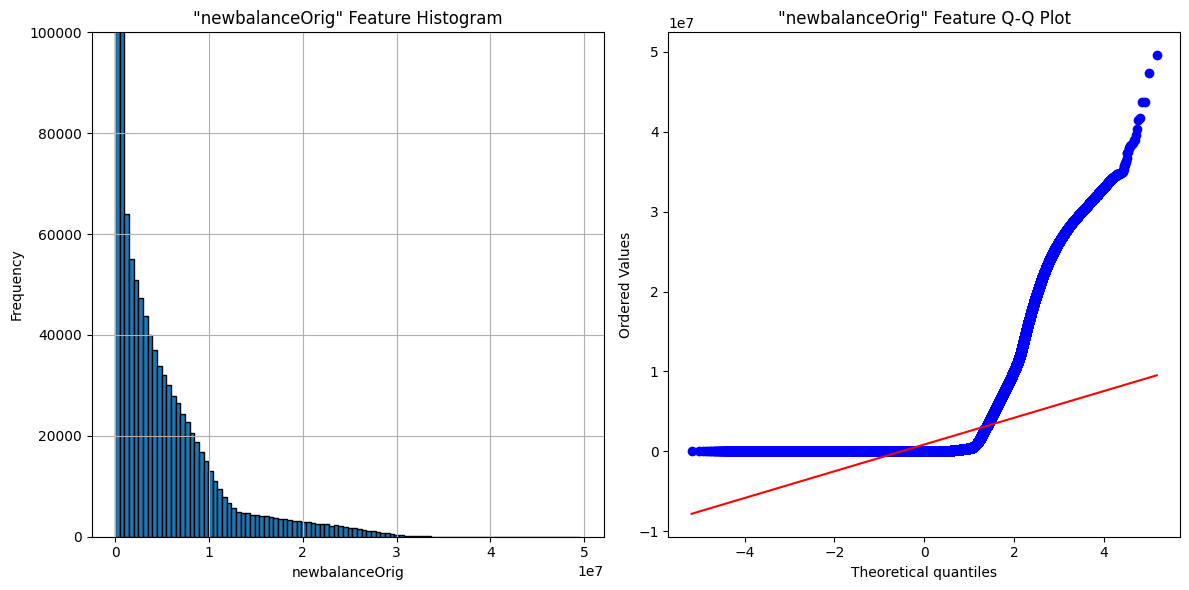

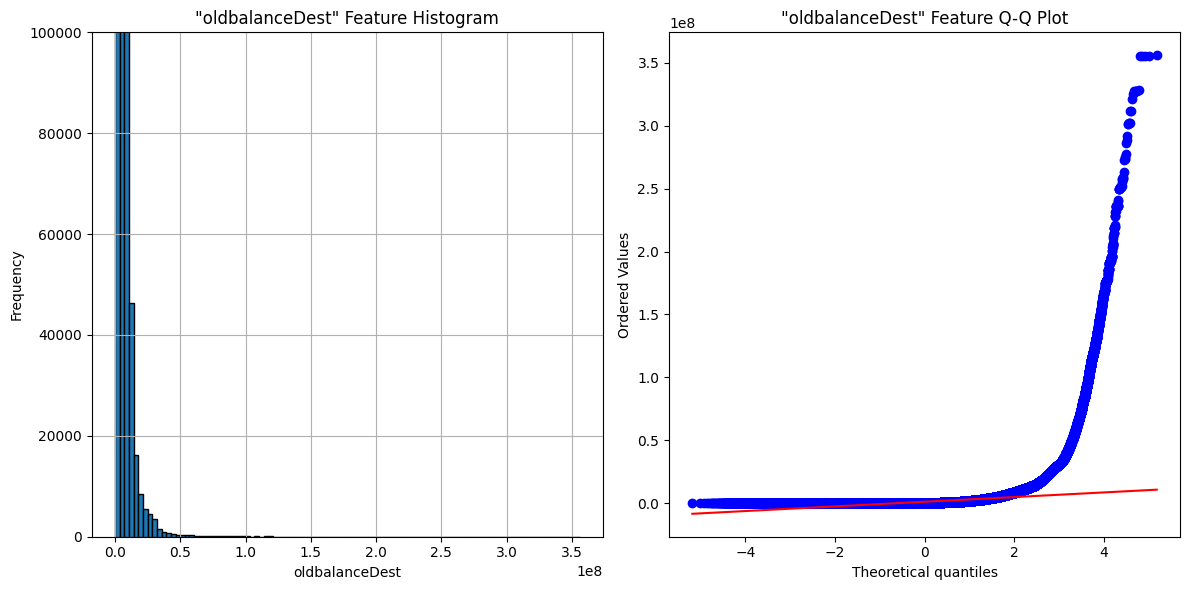

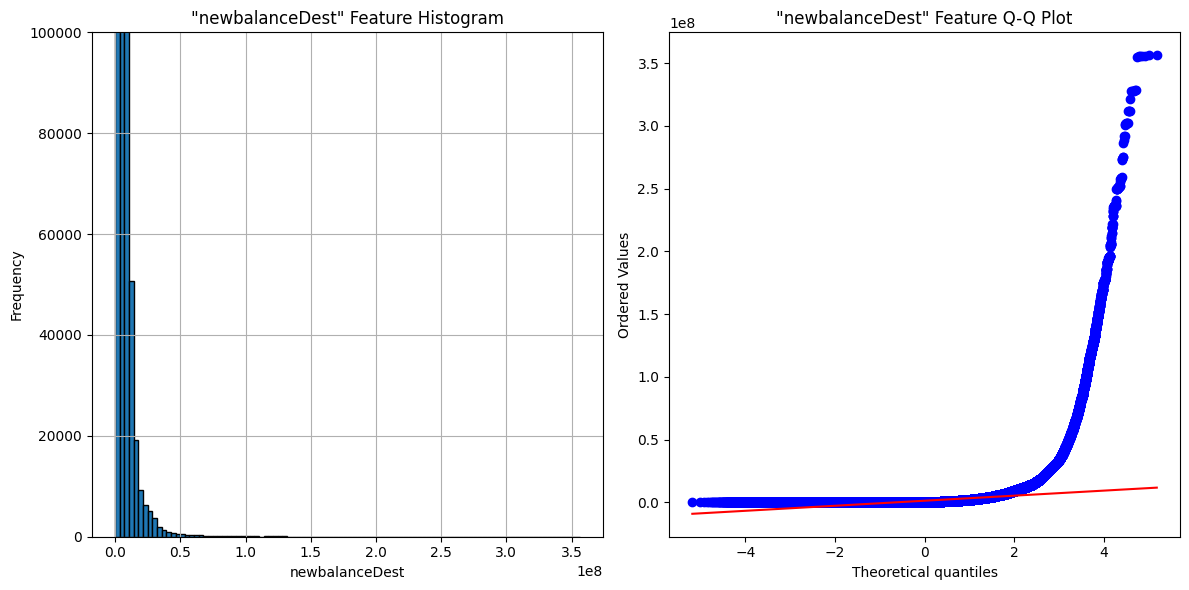

In [7]:
# Define the columns of the DataFrame to plot
columns_to_plot = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Loop through each column in the list to create individual plots
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Create the first subplot (histogram) for the current column
    plt.subplot(1, 2, 1)
    # Plot a histogram of the column to visualize its distribution, using 100 bins for granularity
    df[column].hist(bins=100, edgecolor='black')
    # Set the y-axis limit to focus on a specific range for better visibility of the histogram
    plt.ylim(0, 100000)
    # Set the title to indicate which feature's distribution is being displayed
    plt.title(f'"{column}" Feature Histogram')
    # Label the x-axis with the name of the current column
    plt.xlabel(column)
    # Label the y-axis as 'Frequency' to indicate the count of values within each bin
    plt.ylabel('Frequency')
    
    # Create the second subplot (Q-Q plot) for the current column
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
    # Generate a Q-Q plot to compare the distribution of the column to a normal distribution
    # This helps in assessing the normality of the data
    stats.probplot(df[column].dropna(), dist="norm", plot=plt)
    # Set the title to indicate the Q-Q plot for the current feature
    plt.title(f'"{column}" Feature Q-Q Plot')
    
    # Adjust layout for better visibility of the plots
    plt.tight_layout()
    plt.show()


1. Through the boxplots, it is possible to verify that there is a vast amount of outliers. However, for a dataset of bank transactions, various precautions must be taken since several assumptions must be considered to establish with certainty whether a particular value is indeed an outlier or a "standard" value within the evaluated context. In this sense, no type of treatment will be carried out regarding the outliers.

2. Data normality: Both from the histograms and the Q-Q plots, it is easy to see that the distributions are highly skewed (or non-normal), which can be a problem for models that require normalized data. None of the models that will be tested here require normality; however, one of them requires scaled data.

### __Model training and performance evaluation__

A very important factor to consider before actually training the models is the data preprocessing and the features that will be used.

**Feature Engineering:** Some features will be created to extract implicit aspects from the original dataset's data. Firstly, temporal or "cyclical" data such as day of the week, week of the month, period of the day, etc., are data that can provide important insights in the context of bank transaction frauds. In addition, some other features will be generated in an attempt to observe important aspects when we look at the data we have.

**Encoding of Categorical Features:** For the categorical data features of this project, encoding is necessary, more specifically, encodings of different natures. For low-cardinality features, techniques such as one-hot encoding or similar are sufficient to solve the problem, but for high-cardinality features, greater care must be taken, especially avoiding problems such as an excessive increase in the dataset's dimensionality. In this sense, the chosen technique for this is frequency encoding with the addition of noise. Briefly, this technique will generate values from the count of occurrences that the data of high-cardinality variables appear by assigning their count value to them. To avoid duplicated data for different variables that may have the same count, noise is added in such a way that such data are differentiated.

In [8]:
class CustomFeatureGenerator(BaseEstimator, TransformerMixin):
    # Calculate the day of the week from a 'step' value
    @staticmethod
    def calculate_day_of_week(step):
        # List of days for mapping the day index to a day name
        days = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
        # Calculate day index based on the step value, assuming step is in hours
        day_index = (step // 24) % 7
        return day_index  

    # Determine the part of the day based on the hour
    @staticmethod
    def part_of_day(hour):
        # Categorize the hour of the day into one of four categories
        if 0 <= hour <= 5:
            return 'early morning'
        elif 6 <= hour <= 11:
            return 'morning' 
        elif 12 <= hour <= 17:
            return 'afternoon'
        else:
            return 'night'

    # Check if a day is on the weekend
    @staticmethod
    def is_weekend(day_of_week_num):
        # Weekend is considered as Sunday (0) or Saturday (6)
        return int(day_of_week_num == 0 or day_of_week_num == 6)  

    # Prepare the transformer by determining thresholds and frequency of names
    def fit(self, X, y=None):
        # Calculate low and high thresholds for the 'amount' feature to categorize it later
        self.low_threshold, self.high_threshold = X['amount'].quantile([0.25, 0.75])
        
        # Calculate frequency of occurrences for 'nameOrig' and 'nameDest'
        self.freq_orig = X['nameOrig'].value_counts(normalize=True)
        self.freq_dest = X['nameDest'].value_counts(normalize=True)
        
        return self

    # Transform the input DataFrame by adding new features
    def transform(self, X):
        # Make a copy of the input DataFrame to avoid modifying the original
        X = X.copy()
        # Flag rows where 'nameDest' starts with 'M', indicating a merchant
        X['MerchantFlag'] = X['nameDest'].str.startswith('M').astype(int)
        # Categorize 'amount' into Low, Medium, or High based on calculated thresholds
        X['AmountFlags'] = pd.cut(X['amount'],
                                  bins=[0, self.low_threshold, self.high_threshold, float('inf')],
                                  labels=['Low', 'Medium', 'High'])
        # Map frequencies calculated during fit to 'nameOrig' and 'nameDest'
        X['FrequencyOrig'] = X['nameOrig'].map(self.freq_orig).fillna(0)
        X['FrequencyDest'] = X['nameDest'].map(self.freq_dest).fillna(0)
        # Calculate additional time-related features based on the 'step' value
        X['hour_of_day'] = X['step'] % 24
        X['part_of_day'] = X['hour_of_day'].apply(self.part_of_day)
        X['day_of_week'] = X['step'].apply(self.calculate_day_of_week)
        X['day_of_month'] = np.ceil(X['step'] / 24).astype(int)
        X['week_of_month'] = np.ceil(X['day_of_month'] / 7).astype(int)
        X['is_weekend'] = X['day_of_week'].apply(self.is_weekend)
        
        return X
    
class FrequencyEncodingWithNoise(BaseEstimator, TransformerMixin):
    # Initialize with optional columns list and noise level
    def __init__(self, columns=None, noise_level=0.001):
        self.columns = columns  # Columns to encode
        self.noise_level = noise_level  # Amount of noise to add

    # Fit the transformer to the DataFrame
    def fit(self, X, y=None):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        # Initialize a dictionary to store frequency maps for each column
        self.freq_maps = {}
        for column in self.columns:
            # Ensure the column exists in the DataFrame
            if column not in X.columns:
                raise ValueError(f"Column {column} not in DataFrame")
            
            # Calculate frequencies, add noise, and store in the frequency map
            frequencies = X[column].value_counts(normalize=True)
            noise = np.random.rand(len(frequencies)) * self.noise_level
            self.freq_maps[column] = (frequencies + noise).to_dict()
        return self

    # Transform the DataFrame based on the fitted frequency maps
    def transform(self, X):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        X_transformed = X.copy()
        for column in self.columns:
            # Ensure the column exists for transformation
            if column not in X.columns:
                raise ValueError(f"Column {column} not in DataFrame")
            
            # Apply the frequency map to the column, filling missing values with 0
            X_transformed[column] = X_transformed[column].map(self.freq_maps[column]).fillna(0)
        return X_transformed

In order to facilitate the formatting of the outputs generated by the models, the functions below will be used:

In [9]:
def print_confusion_matrix_table(confusion_matrix, class_names):
    # Convert the confusion matrix into a DataFrame for easier manipulation and readability
    matrix_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    
    # Calculate percentage values for each cell in the confusion matrix to provide insights
    # into the proportion of predictions relative to the actual class distributions
    matrix_percent = 100 * matrix_df.div(matrix_df.sum(axis=1), axis=0)
    
    # Format the matrix with both counts and percentages to give a clear overview of model performance
    formatted_matrix = matrix_df.astype(str) + " (" + matrix_percent.round(3).astype(str) + "%)"
    
    # Set the pandas option to display floats with three decimal places for better readability
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # Print the formatted confusion matrix as a string to display both counts and percentages neatly
    print(formatted_matrix.to_string())

def print_classification_report_table(y_true, y_pred):
    # Generate a classification report as a dictionary, which includes precision, recall,
    # f1-score, and support for each class
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Convert the classification report dictionary into a DataFrame for easier viewing and manipulation
    report_df = pd.DataFrame(report).transpose()
    
    # Round the values in the DataFrame to two decimal places for readability
    print(report_df.round(3))

**Model Training:**

Regarding the creation of the models themselves, four models will be tested: Logistic Regression, Random Forest, CatBoost, and LightGBM. Each model is configured with specific parameters, such as class balancing and maximum number of iterations, to deal with class imbalance.
For each model, the code trains the model using the training set and then evaluates performance using various metrics on the training and test sets. The metrics include classification reports (precision, recall, F1-score) for direct evaluations, and AUC-ROC and Precision-Recall AUC scores to assess the model's ability to discriminate between positive and negative classes.

**Decision Threshold Tuning:**

Application of Probability Thresholds: The code explores different decision thresholds for the model's probability predictions, seeking a balance between the sensitivity and specificity of the predictions.
Detailed Evaluation: For each threshold, classification reports and confusion matrices are generated, providing insights into the performance of the models at different levels of sensitivity to fraud.

In [10]:
# Split the dataset into features (X) and target variable (y)
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Initialize and apply custom feature generator to both training and test sets
custom_feature_gen = CustomFeatureGenerator()
X_train_custom = custom_feature_gen.fit_transform(X_train)
X_test_custom = custom_feature_gen.transform(X_test)

numerical_features = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
    'newbalanceDest', 'hour_of_day', 'day_of_month', 'MerchantFlag',
    'is_weekend', 'day_of_week', 'week_of_month', 'FrequencyOrig', 'FrequencyDest'
]
low_cardinality_categorical_features = ['type', 'part_of_day']
high_cardinality_categorical_features = ['nameOrig', 'nameDest']

# Define pipelines for processing different types of features: numerical, low cardinality categorical, and high cardinality categorical
numerical_pipeline = Pipeline([('scaler', StandardScaler())])
low_cardinality_categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
high_cardinality_categorical_pipeline = Pipeline([
    ('freq_enc', FrequencyEncodingWithNoise(columns=high_cardinality_categorical_features))
])

# Combine the above pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline, numerical_features),
    ('low_cardinality_categorical_pipeline', low_cardinality_categorical_pipeline, low_cardinality_categorical_features),
    ('high_cardinality_categorical_pipeline', high_cardinality_categorical_pipeline, high_cardinality_categorical_features)
])

# Define a dictionary of models to train and evaluate
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=1, n_jobs=-1, verbose=0),
    'CatBoost': CatBoostClassifier(random_state=1, auto_class_weights='Balanced', verbose=0),
    'LightGBM': LGBMClassifier(random_state=1, class_weight='balanced', verbose=-1)
}

# Function to apply a probability threshold to model predictions
def apply_threshold(probas, threshold):
    return (probas[:, 1] >= threshold).astype(int)


# Iterating through each model to train and evaluate them
for model_name, model in models.items():
    print("-------------------------------------------------------------------------------------")
    print(f"Training {model_name}")  # Indicates the start of training for a model
    print("-------------------------------------------------------------------------------------")
    
    # Creating a pipeline with preprocessing steps and the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Applies preprocessing steps defined earlier
        ('classifier', model)  # The model to be trained
    ])
    
    # Fitting the model on the training data
    pipeline.fit(X_train_custom, y_train)
    
    # Predicting on the training set for evaluation
    y_pred_train = pipeline.predict(X_train_custom)
    print(f"{model_name} Training Set Performance")
    # Printing a classification report for the training set predictions
    print_classification_report_table(y_train, y_pred_train)
    # Calculating and printing the AUC-ROC score for the training predictions
    print("Training AUC-ROC:", roc_auc_score(y_train, pipeline.predict_proba(X_train_custom)[:, 1]))
    # Calculating and printing the Precision-Recall AUC score for the training predictions
    print("Training Precision-Recall AUC:", average_precision_score(y_train, pipeline.predict_proba(X_train_custom)[:, 1]))
    print("-------------------------------------------------------------------------------------")
    
    # Predicting probabilities on the test set to apply different thresholds
    y_probs_test = pipeline.predict_proba(X_test_custom)
    
    # Defining a set of thresholds to evaluate model performance at different sensitivity levels
    thresholds = [0.5, 0.65, 0.8, 0.95, 0.98]
    
    # Evaluating model performance at each threshold
    for threshold in thresholds:
        # Applying the specified threshold to the prediction probabilities
        y_pred_test_threshold = apply_threshold(y_probs_test, threshold)
        print(f"Performance at threshold = {threshold}")
        # Printing a classification report for the thresholded predictions
        print_classification_report_table(y_test, y_pred_test_threshold)
        # Calculating and printing the AUC-ROC score for the test predictions
        print("AUC-ROC:", roc_auc_score(y_test, y_probs_test[:, 1]))
        # Calculating and printing the Precision-Recall AUC score for the test predictions
        print("Precision-Recall AUC:", average_precision_score(y_test, y_probs_test[:, 1]))
        
        # Generating and printing a confusion matrix for the thresholded predictions
        cm = confusion_matrix(y_test, y_pred_test_threshold)
        print("\nConfusion Matrix Table:")
        print_confusion_matrix_table(cm, class_names=['Not Fraud', 'Fraud'])
        print("-------------------------------------------------------------------------------------")
    
    print("-------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------
Training Logistic Regression
-------------------------------------------------------------------------------------
Logistic Regression Training Set Performance
              precision  recall  f1-score      support
0                 1.000   0.958     0.979  5083530.000
1                 0.028   0.951     0.055     6566.000
accuracy          0.958   0.958     0.958        0.958
macro avg         0.514   0.955     0.517  5090096.000
weighted avg      0.999   0.958     0.977  5090096.000
Training AUC-ROC: 0.9917637446833306
Training Precision-Recall AUC: 0.6261213918713204
-------------------------------------------------------------------------------------
Performance at threshold = 0.5
              precision  recall  f1-score      support
0                 1.000   0.945     0.972  1270877.000
1                 0.022   0.962     0.043     1647.000
accuracy          0.945   0.945     0.945        0.945


Evaluating the results above, it is clear that among the tested models, LightGBM had the best overall performance. The Random Forest model seems to have had an almost perfect performance; however, it is evident that the performance is reflecting some kind of problem, likely overfitting due to some reason that requires more detailed investigation. Therefore, the model that will be refined is LightGBM, for which we will subsequently carry out the cross-validation step and hyperparameter optimization, in addition to examining the importance of features in the construction and performance of the models.

-------------------------------------------------------------------------------------
Training LightGBM with Randomized Search
-------------------------------------------------------------------------------------


Best Hyperparameters: {'classifier__num_leaves': 127, 'classifier__n_estimators': 200, 'classifier__min_child_samples': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}
LightGBM Training Set Performance
              precision  recall  f1-score     support
0                 1.000   0.996     0.998 5083524.000
1                 0.238   1.000     0.384    6572.000
accuracy          0.996   0.996     0.996       0.996
macro avg         0.619   0.998     0.691 5090096.000
weighted avg      0.999   0.996     0.997 5090096.000
Training AUC-ROC: 0.9999639833011724
Training Precision-Recall AUC: 0.9798158131532839
-------------------------------------------------------------------------------------
Performance at threshold = 0.1
              precision  recall  f1-score     support
0                 1.000   0.994     0.997 1270883.000
1                 0.172   0.999     0.293    1641.000
accuracy          0.994   0.994     0.994       0.994
macro avg         0.586   0.997    

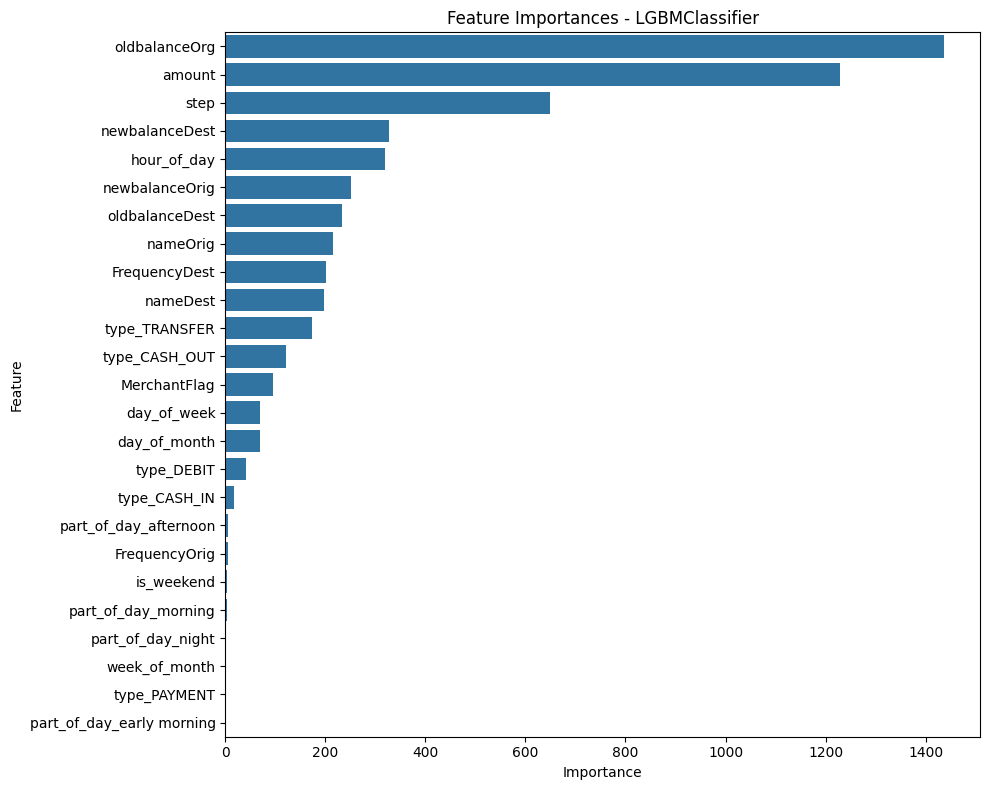

In [12]:
# Essentially, the initial steps are the same as those in the previous code block (kept only for logical continuity).
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

custom_feature_gen = CustomFeatureGenerator()
X_train_custom = custom_feature_gen.fit_transform(X_train)
X_test_custom = custom_feature_gen.transform(X_test)

numerical_features = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
    'newbalanceDest', 'hour_of_day', 'day_of_month', 'MerchantFlag',
    'is_weekend', 'day_of_week', 'week_of_month', 'FrequencyOrig', 'FrequencyDest'
]
low_cardinality_categorical_features = ['type', 'part_of_day']
high_cardinality_categorical_features = ['nameOrig', 'nameDest']  

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

low_cardinality_categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

high_cardinality_categorical_pipeline = Pipeline([
    ('freq_enc', FrequencyEncodingWithNoise(columns=high_cardinality_categorical_features))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline, numerical_features),
    ('low_cardinality_categorical_pipeline', low_cardinality_categorical_pipeline, low_cardinality_categorical_features),
    ('high_cardinality_categorical_pipeline', high_cardinality_categorical_pipeline, high_cardinality_categorical_features)
])

models = LGBMClassifier(random_state=1, class_weight='balanced', verbose=-1)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Definition of the hyperparameter search space for the LGBM classifier
params = {
    'classifier__n_estimators': [100, 200, 300],  # Number of boosted trees to fit
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # Boosting learning rate
    'classifier__num_leaves': [31, 63, 127],  # Maximum tree leaves for base learners
    'classifier__max_depth': [5, 10, 20],  # Maximum tree depth for base learners
    'classifier__min_child_samples': [20, 50, 100]  # Minimum number of data points in a leaf
}

# Setup of RandomizedSearchCV to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    pipeline,  # The pipeline that includes the preprocessing steps and the classifier
    param_distributions=params,  # The hyperparameter space to search
    n_iter=10,  # Number of parameter settings sampled. n_iter trades off runtime vs quality of the solution
    scoring='roc_auc',  # Use AUC-ROC as the score to optimize
    n_jobs=-1,  # Use all available CPUs to speed up the search
    cv=5,  # Number of folds in cross-validation
    random_state=1,  # Seed for reproducibility
    verbose=0  # Level of verbosity. 0 = silent
)

# Start of LightGBM training with Randomized Search for hyperparameter tuning
print("-------------------------------------------------------------------------------------")
print("Training LightGBM with Randomized Search")
print("-------------------------------------------------------------------------------------")
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_custom, y_train)

# After fitting, print the best set of hyperparameters found during the search
print("Best Hyperparameters:", random_search.best_params_)

# Use the best estimator to make predictions on the training set
y_pred_train = random_search.predict(X_train_custom)
print("LightGBM Training Set Performance")
# Print a detailed classification report for the training set predictions
print_classification_report_table(y_train, y_pred_train)
# Calculate and print the AUC-ROC score for the training set predictions
print("Training AUC-ROC:", roc_auc_score(y_train, random_search.predict_proba(X_train_custom)[:, 1]))
# Calculate and print the Precision-Recall AUC score for the training set predictions
print("Training Precision-Recall AUC:", average_precision_score(y_train, random_search.predict_proba(X_train_custom)[:, 1]))
print("-------------------------------------------------------------------------------------")

# Predict probabilities on the test set for further evaluation using different thresholds
y_probs_test = random_search.predict_proba(X_test_custom)

# Define a list of thresholds to evaluate the model's performance on the test set
thresholds = [0.1, 0.35, 0.5, 0.65, 0.8, 0.95, 0.98]

# Iterate over each defined threshold to evaluate model performance on the test set
for threshold in thresholds:
    # Apply the threshold to the second column of y_probs_test which contains the probabilities of the positive class
    y_pred_test_threshold = (y_probs_test[:, 1] >= threshold).astype(int)
    
    # Print the current threshold being evaluated
    print(f"Performance at threshold = {threshold}")
    
    # Print a classification report to see precision, recall, f1-score, and support for the binary classifications at this threshold
    print_classification_report_table(y_test, y_pred_test_threshold)
    
    # Print the AUC-ROC score which evaluates the model's ability to discriminate between the classes
    print("AUC-ROC:", roc_auc_score(y_test, y_probs_test[:, 1]))
    
    # Print the Precision-Recall AUC score which is especially useful for imbalanced datasets
    print("Precision-Recall AUC:", average_precision_score(y_test, y_probs_test[:, 1]))
    
    # Calculate the confusion matrix for the current threshold
    cm = confusion_matrix(y_test, y_pred_test_threshold)
    
    # Print a nicely formatted confusion matrix table to visualize true positives, false positives, true negatives, and false negatives
    print("\nConfusion Matrix Table:")
    print_confusion_matrix_table(cm, class_names=['Not Fraud', 'Fraud'])
    
    # Separator for readability
    print("-------------------------------------------------------------------------------------")

# Final print statement to signify the end of the model evaluation process
print("-------------------------------------------------------------------------------------")
print("Model training and evaluation with optimized hyperparameters and thresholds is complete.")
print("-------------------------------------------------------------------------------------")

# Extract the classifier from the best estimator found by RandomizedSearchCV
lgbm_classifier = random_search.best_estimator_.named_steps['classifier']

# Get the feature importances from the LightGBM model
feature_importances = lgbm_classifier.feature_importances_

# Define feature names for numeric and categorical features
# Numeric features are taken directly as they are
numeric_feature_names = numerical_features

# Categorical feature names are obtained from the one-hot encoder within the pipeline
# This includes creating feature names for each category within the original features
categorical_feature_names = random_search.best_estimator_.named_steps['preprocessor'].named_transformers_['low_cardinality_categorical_pipeline'].named_steps['onehot'].get_feature_names_out()

# High cardinality features are listed as they are, assuming no transformation beyond frequency encoding
high_cardinality_feature_names = high_cardinality_categorical_features  

# Combine all feature names into a single array for labeling purposes
all_feature_names = np.array(numeric_feature_names + list(categorical_feature_names) + high_cardinality_feature_names)

# Sort the features by their importance scores in descending order
sorted_idx = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = all_feature_names[sorted_idx]

# Create a bar plot to visualize the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, orient='h')

# Add titles and labels to enhance readability
plt.title('Feature Importances - LGBMClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Ensure the layout is tight so that no label is cut off
plt.tight_layout()

# Display the plot
plt.show()

### **Results**

Observing the LightGBM Classifier model used, we see that through hyperparameter optimization there was a slight increase in its performance compared to when its hyperparameters were not optimized. It's important to note that there is still a large search space and other hyperparameters that can be optimized, but were not explored here both due to the computational capacity of the machines that ran the experiment and because it was not necessary given the purposes of the project being built. The strategy of using different probability thresholds is especially useful here given the data imbalance which, as seen in the previous exploration, is significant. There are various strategies and techniques to deal with class imbalance, but given the problem analyzed, the size of the dataset, and the computational capacity of the machine used, the strategy employed was that of probability thresholds.
It was possible to verify that given the class imbalance, higher threshold values tend to perform better, significantly and consistently reducing the occurrence of 'false positives', but, on the other hand, slightly increasing the events of 'false negatives'.

### **Feature Importance**

As we can see from the generated graph, some variables have little or practically no importance regarding the model's performance, but as expected, some of them have immense importance. For an application that will be used in the real world, it is of utmost importance to eliminate variables that do not affect or negatively affect the model, in addition to trying to fully explore the features that can improve it. Here, in our case, it is possible to see that several of these variables could be excluded. Moreover, as imagined, variables such as 'step', 'amount', and others have great importance in the results.

## **Conclusions**

The problem of detecting fraud in banking transactions is a highly relevant issue today and is likely to remain an extremely significant problem in the coming years. Physical currency, as previously known, is dying in most countries around the world, and this trend is expected to increase. In this context, transactions are predominantly digital, through banking means, thus opening gaps for fraud and criminal forms of banking transactions. In this sense, developing techniques that can reduce and possibly definitively prevent fraud is of extreme necessity today. For obvious reasons, developing such a solution is not trivial and not easy to implement. Thus, in this project, it was possible to have a glimpse of the types of data worked with for situations like these, challenges, models, and trade-offs. For example, depending on the evaluated situation, it might be less bad to have more false positives than false negatives, and vice versa. Therefore, understanding the trade-offs and how they affect the environment they are inserted in and for the purposes they are being made are factors that must be analyzed on a case-by-case basis.